In [2]:
library("tidyverse")
library("janitor")

In [5]:
trees <- read_csv("2015_Street_Tree_Census_-_Tree_Data_20241001.csv")  %>%
  clean_names()  %>%
  select(tree_id, block_id, tree_dbh, spc_common, status, health,
         postcode, borough, latitude, longitude, borocode)
head(trees)

Rows: 683788 Columns: 45
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (26): created_at, curb_loc, status, health, spc_latin, spc_common, stewa...
dbl (19): tree_id, block_id, tree_dbh, stump_diam, postcode, community board...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


tree_id block_id tree_dbh spc_common      status health postcode borough  
1 180683  348711    3       red maple       Alive  Fair   11375    Queens   
2 200540  315986   21       pin oak         Alive  Fair   11357    Queens   
3 204026  218365    3       honeylocust     Alive  Good   11211    Brooklyn 
4 204337  217969   10       honeylocust     Alive  Good   11211    Brooklyn 
5 189565  223043   21       American linden Alive  Good   11215    Brooklyn 
6 190422  106099   11       honeylocust     Alive  Good   10023    Manhattan
  latitude longitude borocode
1 40.72309 -73.84422 4       
2 40.79411 -73.81868 4       
3 40.71758 -73.93661 3       
4 40.71354 -73.93446 3       
5 40.66678 -73.97598 3       
6 40.77005 -73.98495 1

In [41]:
zip_counts <- trees  %>% 
  group_by(postcode, borough)  %>%
  summarize(num_trees = n())  %>% 
  rename(zip = postcode)
head(zip_counts)

`summarise()` has grouped output by 'postcode'. You can override using the
`.groups` argument.


zip   borough   num_trees
1    83 Manhattan  935     
2 10001 Manhattan  911     
3 10002 Manhattan 2265     
4 10003 Manhattan 2025     
5 10004 Manhattan  118     
6 10005 Manhattan  144

In [8]:
boro_counts <- trees  %>%
  group_by(borough)  %>%
  summarize(num_trees = n())  %>%
  mutate(boro_pop = case_when(
    borough == "Bronx" ~ 1472654,
    borough == "Brooklyn" ~ 2736074,
    borough == "Manhattan" ~ 1694251,
    borough == "Queens" ~ 2405464,
    borough == "Staten Island" ~ 495747
  ),
  boro_area = case_when(
      borough == "Bronx" ~ 42.2,
      borough == "Brooklyn" ~ 69.4,
      borough == "Manhattan" ~ 22.7,
      borough == "Queens" ~ 108.7,
      borough == "Staten Island" ~ 57.5
    ),
  trees_per_capita = num_trees / boro_pop,
  trees_per_sq_mi = num_trees / boro_area
  )

boro_counts

borough       num_trees boro_pop boro_area trees_per_capita trees_per_sq_mi
1 Bronx          85203    1472654   42.2     0.05785677       2019.028       
2 Brooklyn      177293    2736074   69.4     0.06479832       2554.654       
3 Manhattan      65423    1694251   22.7     0.03861470       2882.070       
4 Queens        250551    2405464  108.7     0.10415911       2304.977       
5 Staten Island 105318     495747   57.5     0.21244304       1831.617

# Land and Population Data sourced from Wikipedia: https://en.wikipedia.org/wiki/Boroughs_of_New_York_City#Background

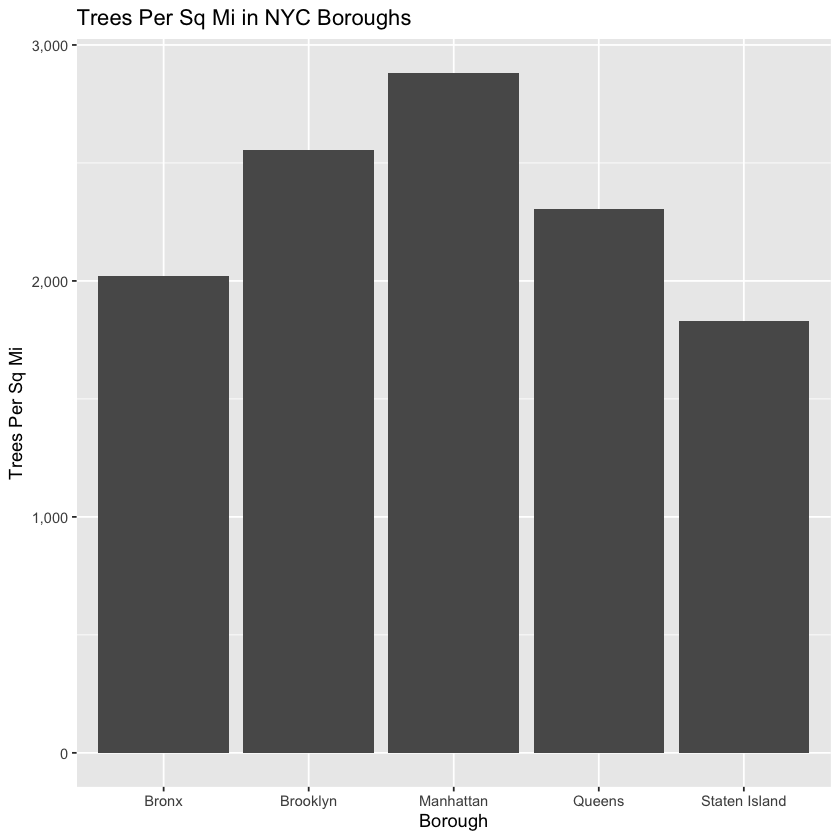

In [9]:
tree_coverage_bar <- ggplot(boro_counts) +
  aes(x = borough, y = trees_per_sq_mi) +
  geom_col() +
  scale_y_continuous(labels = scales::comma) +
  labs(title = "Trees Per Sq Mi in NYC Boroughs",
       x = "Borough",
       y = "Trees Per Sq Mi")

tree_coverage_bar

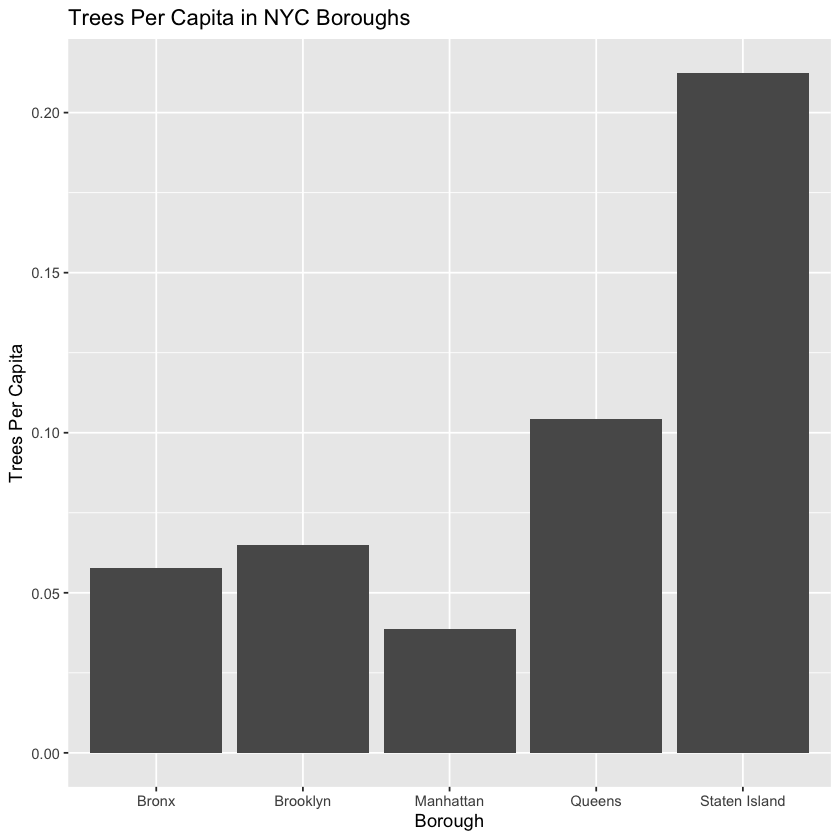

In [10]:
trees_per_capita_bar <- ggplot(boro_counts) +
  aes(x = borough, y = trees_per_capita) +
  geom_col() +
  scale_y_continuous(labels = scales::comma) +
  labs(title = "Trees Per Capita in NYC Boroughs",
       x = "Borough",
       y = "Trees Per Capita")

trees_per_capita_bar


In [7]:
install.packages("rjson")


The downloaded binary packages are in
	/var/folders/5k/k9z7r_vs0098fm1rwf519ml40000gn/T//RtmpWyF7uY/downloaded_packages


In [11]:
library(plotly)
library(rjson)

zipcode_json <- fromJSON(file="nyc-zip-code-tabulation-areas-polygons.geojson")
g <- list(

  fitbounds = "locations",

  visible = FALSE

)
fig <- plot_ly()

fig <- fig  %>% add_trace(
  type = "choropleth",
  geojson = zipcode_json,
  locations = zip_counts$zip,
  z = zip_counts$num_trees,
  featureidkey="properties.postalCode"
)

fig <- fig %>% layout(geo = g, title = "Number of Trees in NYC Zip Codes")

fig


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout




HTML widgets cannot be represented in plain text (need html)

# Census Data
So we can compare tree count with ZCTA median income

In [42]:
income_data <- read_csv("ACSST5Y2015.S1901_2024-10-09T153412/ACSST5Y2015.S1901-Data.csv")  %>%
  clean_names()  %>%
  select(name, s1901_c01_012e, s1901_c01_012m) %>% # just selecting median household income and margin of error
  rename(median_income = s1901_c01_012e, income_margin = s1901_c01_012m)  %>%
  mutate(zip = substring(name, 7, nchar(name)))  %>% # dropping the "ZCTA5 " part of the zipcode field 
  filter(nchar(zip) == 5)  %>%  # filtering out the first two rows that give stats about NYC metro and extra column names (don't need at this point) 
  select(zip, median_income, income_margin) # get rid of name now that we've gotten what we need out of it

# converting the data types of the columns to numbers so it meshes with zip_counts and graphs easily
income_data$zip = as.numeric(income_data$zip)
income_data$median_income = as.numeric(income_data$median_income)
income_data$income_margin = as.numeric(income_data$income_margin)
#income_data <- income_data  %>% column_to_rownames(var = "zip")
head(income_data)

New names:
* `` -> `...131`
Rows: 1796 Columns: 131
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (130): GEO_ID, NAME, S1901_C01_001E, S1901_C01_001M, S1901_C02_001E, S19...
lgl   (1): ...131

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


zip   median_income income_margin
1  6390 151083        13297        
2 10001  86801        10346        
3 10002  33726         3127        
4 10003  98151         5628        
5 10004 119691        15833        
6 10005 124194        10342

In [43]:
income_data

zip   median_income income_margin
1     6390 151083        13297        
2    10001  86801        10346        
3    10002  33726         3127        
4    10003  98151         5628        
5    10004 119691        15833        
6    10005 124194        10342        
7    10006 123691        27459        
8    10007     NA           NA        
9    10009  59090         5355        
10   10010 101718         7116        
11   10011 109818         7540        
12   10012 100859         5399        
13   10013  96667        17159        
14   10014 113973        10369        
15   10016 104826         5131        
16   10017 106421        12463        
17   10018 105500        11540        
18   10019  94022         5480        
19   10020     NA           NA        
20   10021 115076        13697        
21   10022 126378         8059        
22   10023 111478        10254        
23   10024 113839         5687        
24   10025  74065         4869        
25   10026  47264         4441        
26   10027  40782         3120        
27   10028 114939         6716        
28   10029  31350         1805        
29   10030  33196         2758        
30   10031  39774         3792        
...  ...   ...           ...          
1765 14865 37821          4658        
1766 14867 44306          7130        
1767 14869 49231          5605        
1768 14870 62813          4804        
1769 14871 62212          7621        
1770 14872 51958          9579        
1771 14873 46987          2608        
1772 14874 34028         14594        
1773 14877 51094          8565        
1774 14878 69318         25997        
1775 14879 47214          9471        
1776 14880 49922          9983        
1777 14881    NA            NA        
1778 14882 69097         18952        
1779 14883 51447          6874        
1780 14884 47500          9442        
1781 14885 47375         12565        
1782 14886 66450          5362        
1783 14889 49853          8206        
1784 14891 44104          4242        
1785 14892 50253          5873        
1786 14893    NA            NA        
1787 14894 39750         10427        
1788 14895 41102          1991        
1789 14897 45789          5057        
1790 14898 37941          5015        
1791 14901 26766          2697        
1792 14903 49267          5042        
1793 14904 38020          3201        
1794 14905 64178          5702

In [44]:
zip_trees_income <- left_join(x = zip_counts, y = income_data, by = "zip")  %>% 
  filter(zip != 83) # central park is zip 00083, lack of income data messes things up

head(zip_trees_income)


zip   borough   num_trees median_income income_margin
1 10001 Manhattan  911       86801        10346        
2 10002 Manhattan 2265       33726         3127        
3 10003 Manhattan 2025       98151         5628        
4 10004 Manhattan  118      119691        15833        
5 10005 Manhattan  144      124194        10342        
6 10006 Manhattan   53      123691        27459

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 12 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`)."


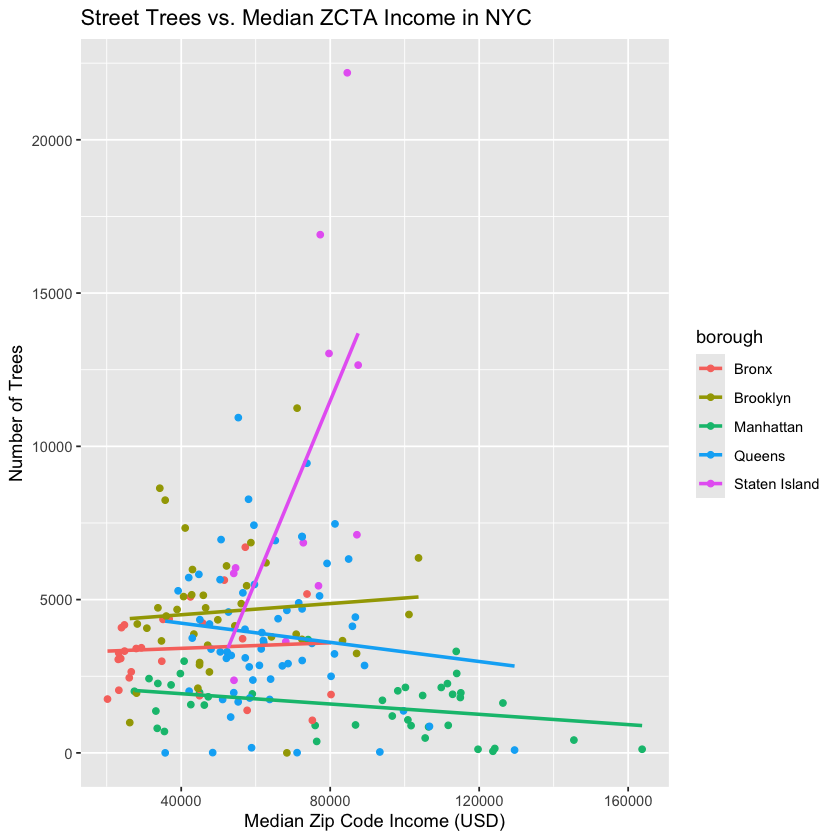

In [46]:
ggplot(zip_trees_income, aes(x = median_income, y = num_trees, color = borough)) + geom_point() +
  geom_smooth(method = lm, se = FALSE) +
  labs(title = "Street Trees vs. Median ZCTA Income in NYC",
    x = "Median Zip Code Income (USD)",
    y = "Number of Trees")

In [ ]:
zcta_areas <- read_csv()